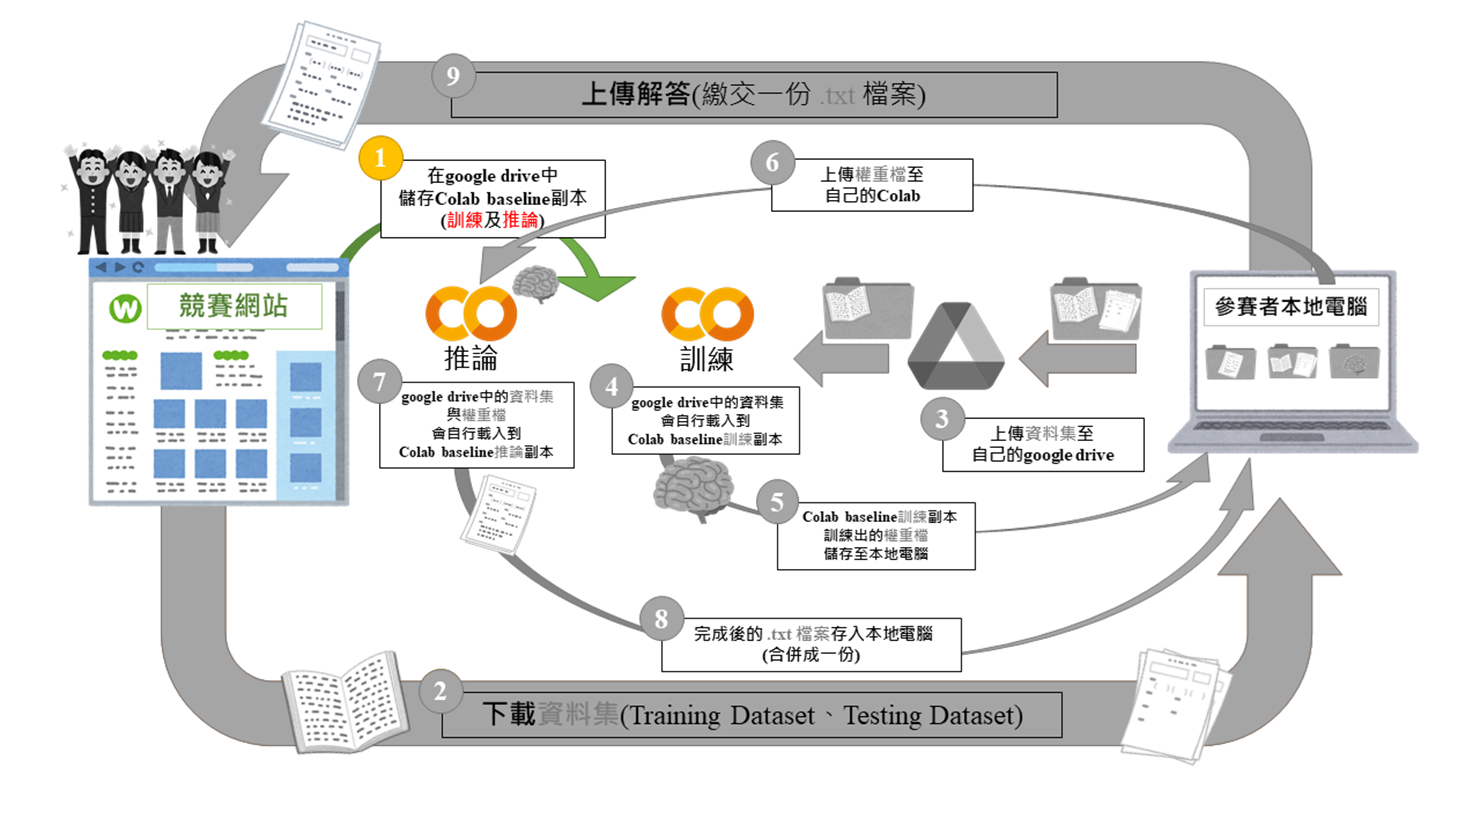

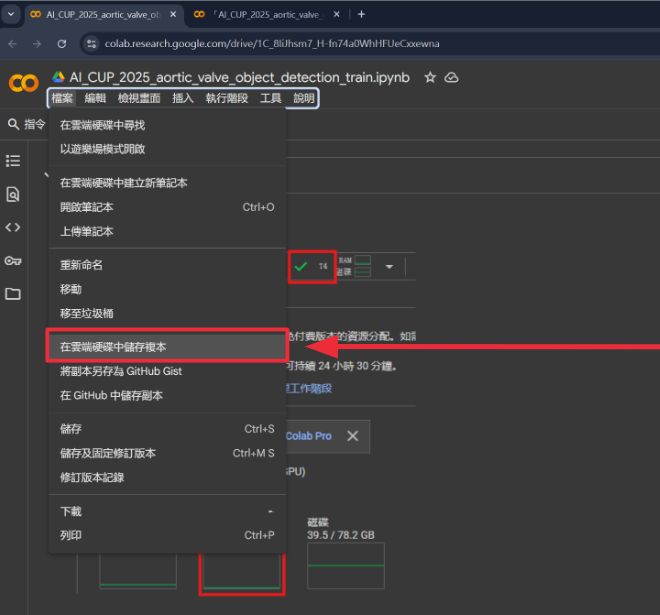

#### 1.設置環境

從畫面右上角確認有使用到GPU

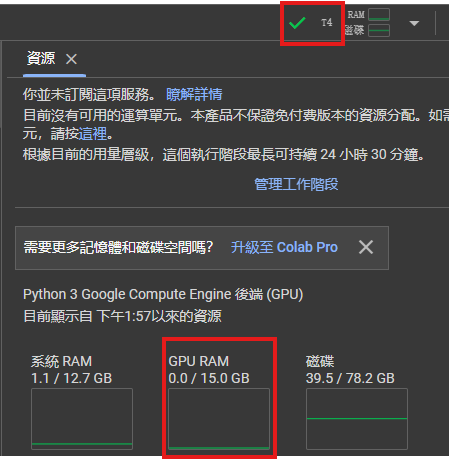

如果沒連到的話請切換到GPU

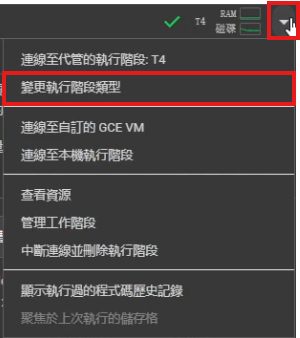
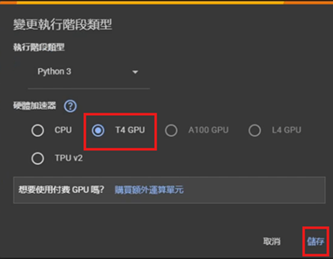

Colab區塊左方有綠色勾代表執行完成且成功 image.png


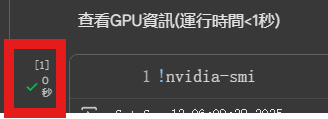

區塊左方有圈在轉代表執行中 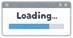

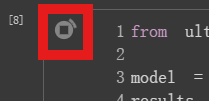

區塊左方有紅色驚嘆號代表運行錯誤 image.png

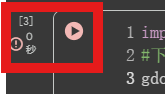

查看GPU資訊(運行時間<1秒) image.png

In [ ]:
!nvidia-smi

Thu Nov 27 10:43:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

確保不會出現編碼錯誤(運行時間<1秒) image.png

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

下載YOLOv12套件(運行時間12秒) image.png

In [ ]:
!pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 38.1/112.6 GB disk)


#### 2. 上傳資料集和 .yaml 檔

.yaml 檔內容

.yaml 範例:https://drive.google.com/file/d/13hSr3sa2wOZqlvY1RAwr2msCfTdkfjMe/view?usp=sharing

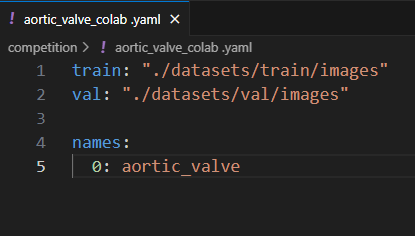



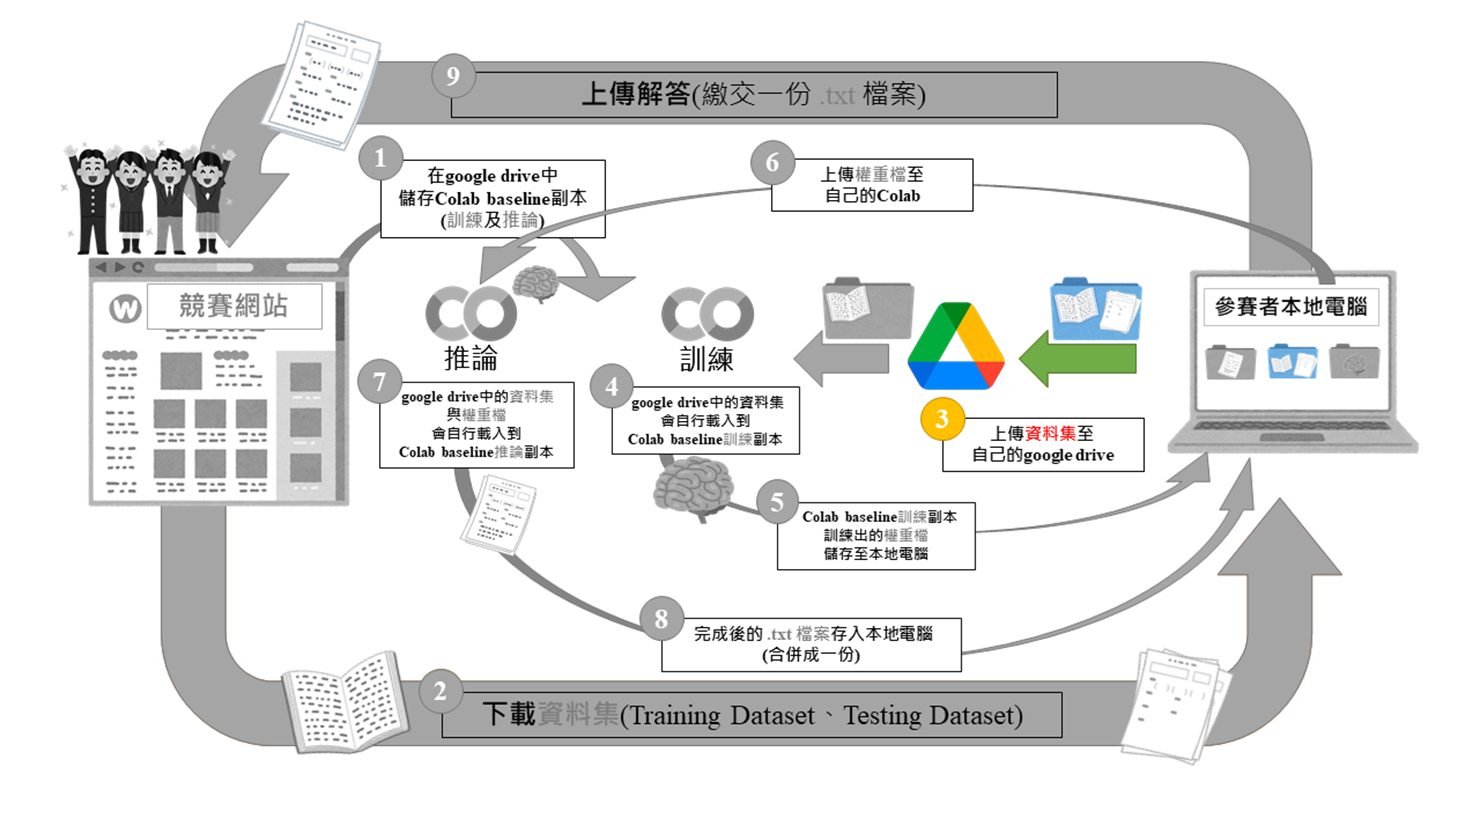

上傳資料集


將training_image.zip、training_label.zip和aortic_valve_colab.yaml上傳至個人的Google雲端硬碟


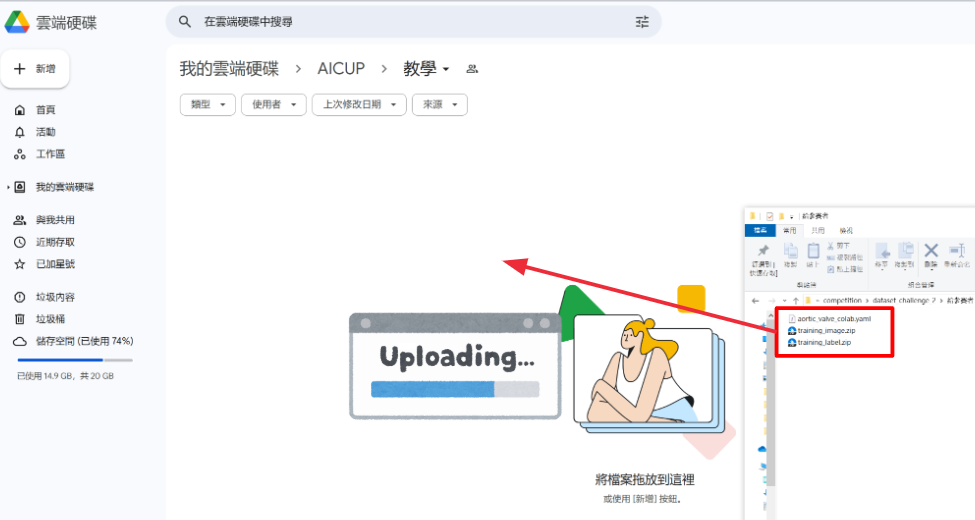

更改檔案權限(training_image.zip、training_label.zip和aortic_valve_colab.yaml**三個檔案權限都要更改**) image.png

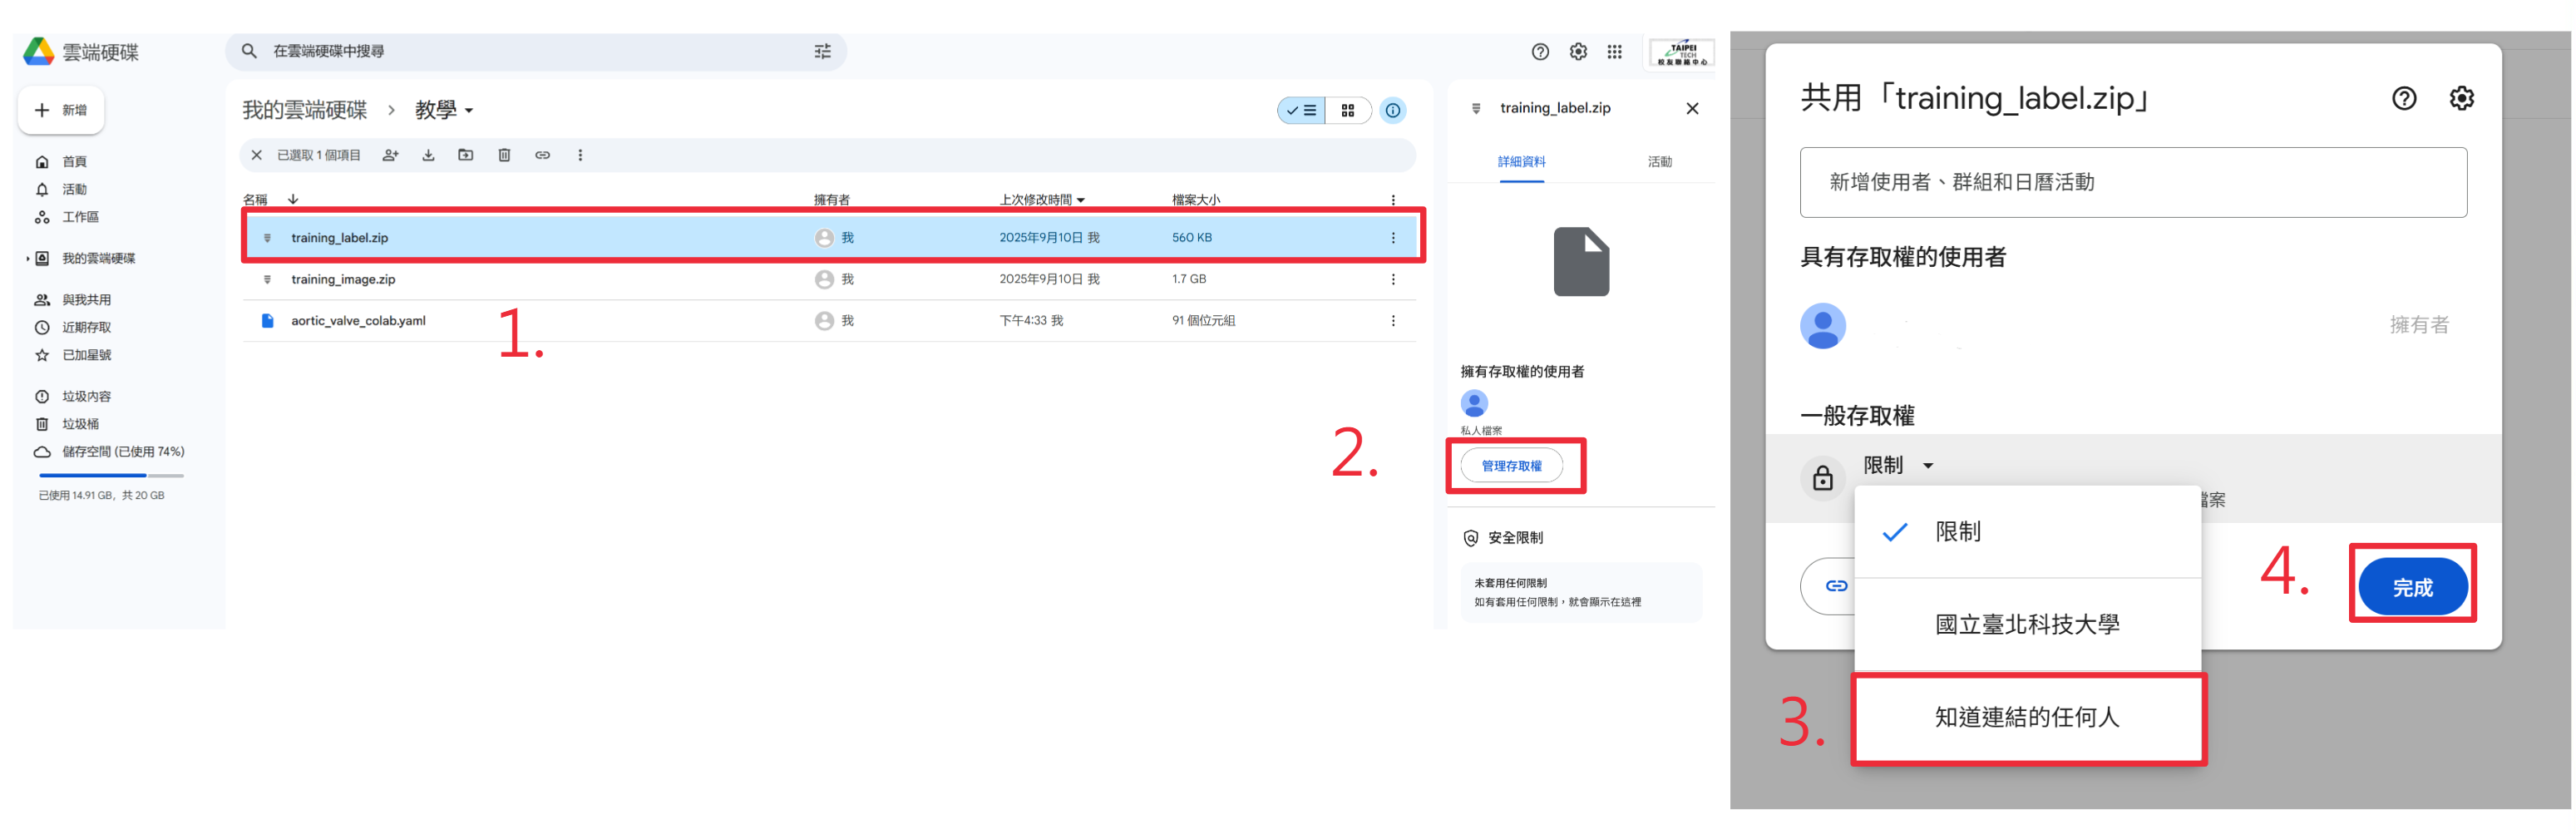

取得雲端資料下載連結(下方程式需要用到)
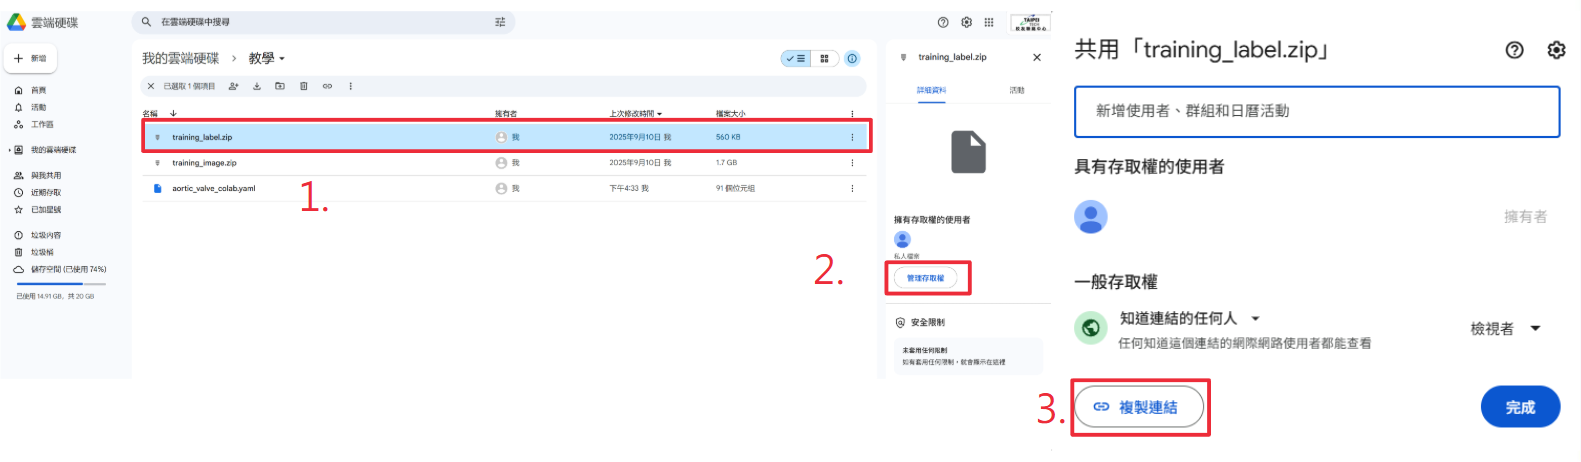

將剛剛取得的網址透過下方網址轉換成直接下載的格式


https://sites.google.com/view/twdrivefromdownload/%E7%B9%81%E9%AB%94%E4%B8%AD%E6%96%87traditional-chinese?authuser=0

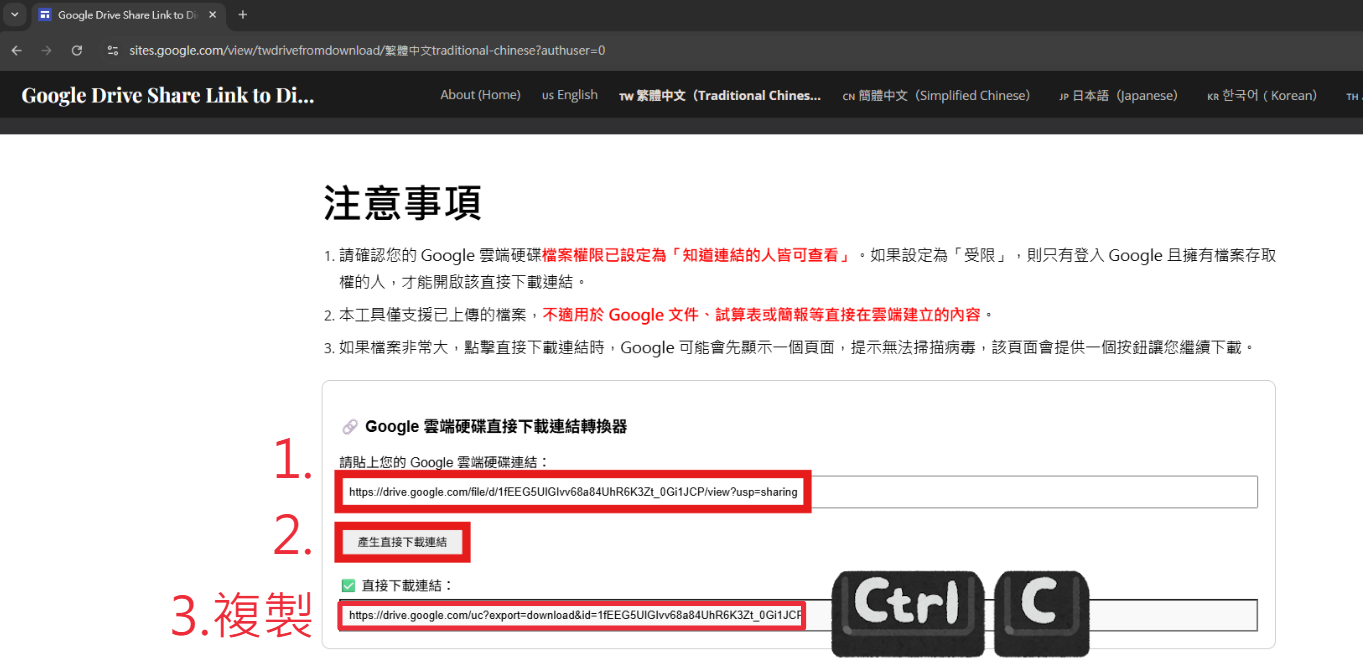

透過上面方法更改下方程式的三個網址(執行時間<1分鐘) image.png


 *請自行上傳雲端替換成自己的連結，此範例連結雖然與最初競賽資料集相同，但不保證會更新且隨時有可能會刪除!!!

In [ ]:
import gdown
import os
import shutil

#下載training_image.zip
gdown.download("https://drive.google.com/uc?export=download&id=1zy_ZEZ_4uNCsexlg8aGS8Wv_jPn58uXG","/content/training_image.zip")
#下載training_label.zip
gdown.download("https://drive.google.com/uc?export=download&id=1HeYgPOqLA3YsIixZe3v4g2w_L4cXqmo2","/content/training_label.zip")
#下載訓練aortic_valve_colab.yaml
gdown.download("https://drive.google.com/uc?export=download&id=1St7hpd7ODbmMShkUES5RIhytI2bbEnrD","/content/aortic_valve_colab.yaml", fuzzy=True) # Added fuzzy=True based on gdown warning

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1zy_ZEZ_4uNCsexlg8aGS8Wv_jPn58uXG
From (redirected): https://drive.google.com/uc?export=download&id=1zy_ZEZ_4uNCsexlg8aGS8Wv_jPn58uXG&confirm=t&uuid=2376ddf3-df82-4da4-928e-e708fa23edc4
To: /content/training_image.zip
100%|██████████| 1.83G/1.83G [00:21<00:00, 84.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1HeYgPOqLA3YsIixZe3v4g2w_L4cXqmo2
To: /content/training_label.zip
100%|██████████| 659k/659k [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1St7hpd7ODbmMShkUES5RIhytI2bbEnrD
To: /content/aortic_valve_colab.yaml
100%|██████████| 91.0/91.0 [00:00<00:00, 377kB/s]


'/content/aortic_valve_colab.yaml'

移動檔案(透過下方程式，執行時間<1分鐘)


此範例將前30筆資料用於訓練，後20筆資料用於驗證，參賽者可在程式中53行及56行更改比例

因為Colab運算資源有限此處只採用有標註檔的圖片，其餘圖片也可以自行修改程式利用

將前30筆資料的圖片全部移動至./datasets/train/images，


 前30筆資料的標註全部移動至./datasets/train/labels，


 後20筆資料的圖片全部移動至./datasets/val/images，


 後20筆資料的標註全部移動至./datasets/val/labels。


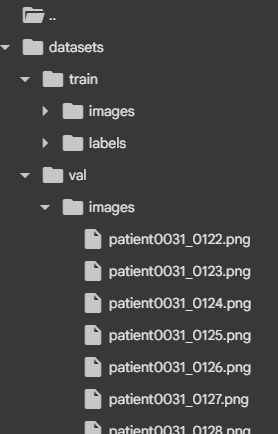

不加入未標註圖片

In [ ]:
#移動檔案
def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 解壓縮到固定資料夾
if not os.path.isdir("./training_image") and os.path.exists("training_image.zip"):
    os.makedirs("./training_image", exist_ok=True)
    !unzip -q training_image.zip -d ./training_image

if not os.path.isdir("./training_label") and os.path.exists("training_label.zip"):
    os.makedirs("./training_label", exist_ok=True)
    !unzip -q training_label.zip -d ./training_label

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立輸出資料夾
os.makedirs("./datasets/train/images", exist_ok=True)
os.makedirs("./datasets/train/labels", exist_ok=True)
os.makedirs("./datasets/val/images", exist_ok=True)
os.makedirs("./datasets/val/labels", exist_ok=True)

def move_patients(start, end, split):
    for i in range(start, end + 1):
        patient = f"patient{i:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)
        if not os.path.isdir(lbl_dir):
            continue

        for fname in os.listdir(lbl_dir):
            if not fname.endswith(".txt"):
                continue

            label_path = os.path.join(lbl_dir, fname)
            base, _ = os.path.splitext(fname)  # 取出檔名不含副檔名
            img_path = os.path.join(img_dir, base + ".png")
            if not os.path.exists(img_path):
                print(f"找不到對應圖片: {img_path}")
                continue

            shutil.move(img_path, f"./datasets/{split}/images/")
            shutil.move(label_path, f"./datasets/{split}/labels/")

# patient0001~0030 → train
move_patients(1, 30, "train")

# patient0031~0050 → val
move_patients(31, 50, "val")

print("完成移動！")

IMG_ROOT = ./training_image/training_image
LBL_ROOT = ./training_label/training_label
完成移動！


加入未標註圖片


In [ ]:
# 移動檔案
def find_patient_root(root):
    """往下找，直到找到含有 patientXXXX 的資料夾"""
    for dirpath, dirnames, filenames in os.walk(root):
        if any(d.startswith("patient") for d in dirnames):
            return dirpath
    return root  # fallback

# 解壓縮到固定資料夾
if not os.path.isdir("./training_image") and os.path.exists("training_image.zip"):
    os.makedirs("./training_image", exist_ok=True)
    !unzip -q training_image.zip -d ./training_image

if not os.path.isdir("./training_label") and os.path.exists("training_label.zip"):
    os.makedirs("./training_label", exist_ok=True)
    !unzip -q training_label.zip -d ./training_label

IMG_ROOT = find_patient_root("./training_image")
LBL_ROOT = find_patient_root("./training_label")

print("IMG_ROOT =", IMG_ROOT)
print("LBL_ROOT =", LBL_ROOT)

# 建立輸出資料夾
os.makedirs("./datasets/train/images", exist_ok=True)
os.makedirs("./datasets/train/labels", exist_ok=True)
os.makedirs("./datasets/val/images", exist_ok=True)
os.makedirs("./datasets/val/labels", exist_ok=True)

def move_patients(start, end, split):
    for i in range(start, end + 1):
        patient = f"patient{i:04d}"
        img_dir = os.path.join(IMG_ROOT, patient)
        lbl_dir = os.path.join(LBL_ROOT, patient)

        if not os.path.isdir(img_dir):
            continue

        # 「有標註的圖片」的 base 名稱 (去除 .txt)
        labeled_basenames = set()

        # 1️⃣ 先處理有標註的圖片
        if os.path.isdir(lbl_dir):
            for fname in os.listdir(lbl_dir):
                if not fname.endswith(".txt"):
                    continue

                base, _ = os.path.splitext(fname)
                labeled_basenames.add(base)

                label_path = os.path.join(lbl_dir, fname)
                img_path = os.path.join(img_dir, base + ".png")

                if not os.path.exists(img_path):
                    print(f"找不到對應圖片: {img_path}")
                    continue

                shutil.move(img_path, f"./datasets/{split}/images/")
                shutil.move(label_path, f"./datasets/{split}/labels/")

        # 2️⃣ 再處理沒有標註的圖片（新增的功能）
        for fname in os.listdir(img_dir):
            if not fname.endswith(".png"):
                continue

            base, _ = os.path.splitext(fname)

            # 如果這張圖片沒有對應 txt → 未標註圖片
            if base not in labeled_basenames:
                img_path = os.path.join(img_dir, fname)
                shutil.move(img_path, f"./datasets/{split}/images/")
                print(f"未標註圖片加入資料集：{img_path}")

# patient0001~0030 → train
move_patients(1, 30, "train")

# patient0031~0050 → val
move_patients(31, 50, "val")

print("完成移動！")


串流輸出內容已截斷至最後 5000 行。
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0066.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0036.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0032.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0343.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0045.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0120.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0081.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0101.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0126.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0168.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0381.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_0207.png
未標註圖片加入資料集：./training_image/training_image/patient0034/patient0034_

確認檔案是否成功移動 image.png

如果資料數量符合下圖數量代表移動成功

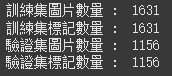

In [ ]:
!ls

aortic_valve_colab.yaml  training_image      training_label
datasets		 training_image.zip  training_label.zip


In [ ]:
print('訓練集圖片數量 : ',len(os.listdir("./datasets/train/images")))
print('訓練集標記數量 : ',len(os.listdir("./datasets/train/labels")))
print('驗證集圖片數量 : ',len(os.listdir("./datasets/val/images")))
print('驗證集標記數量 : ',len(os.listdir("./datasets/val/labels")))

訓練集圖片數量 :  9929
訓練集標記數量 :  1631
驗證集圖片數量 :  6934
驗證集標記數量 :  1156


#### 3. 訓練模型(運行時間約15分鐘)

執行後依序有Epoch在跑代表成功

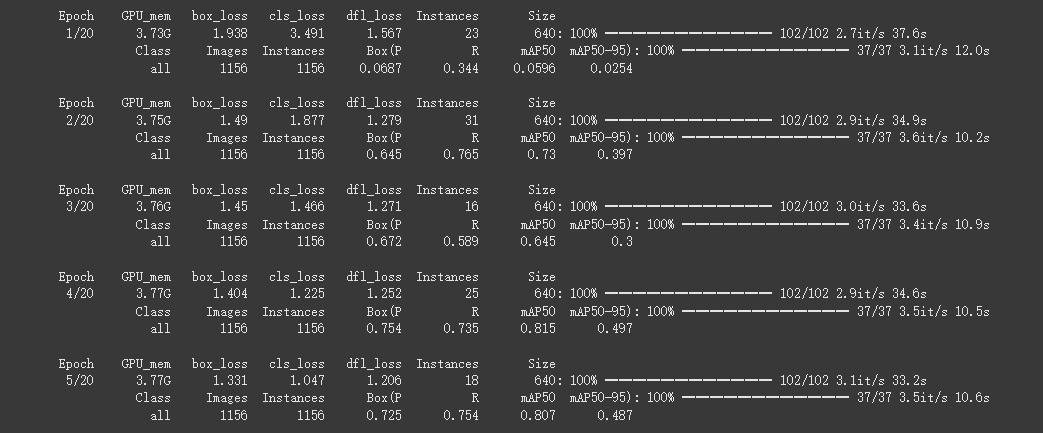

In [ ]:
from ultralytics import YOLO

model = YOLO('yolo12n.pt') #初次訓練使用YOLO官方的預訓練模型，如要使用自己的模型訓練可以將'yolo12n.pt'替換掉
results = model.train(data="./aortic_valve_colab.yaml",
            epochs=30, #跑幾個epoch
            batch=16, #batch_size
            imgsz=640, #圖片大小640*640
            device=0 #使用GPU進行訓練
            )

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=./aortic_valve_colab.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, p

訓練完左方檔案會有run資料夾，此份Colab主要目標是得到best.pt用於下一份Colab進行預測image.png

(!!如果有重複訓練**請下載最後成功**的train編號資料夾)

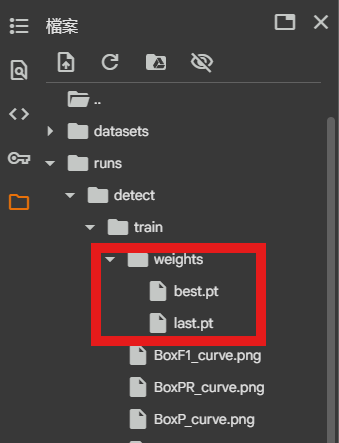

#### 4. 壓縮並下載訓練完的模型

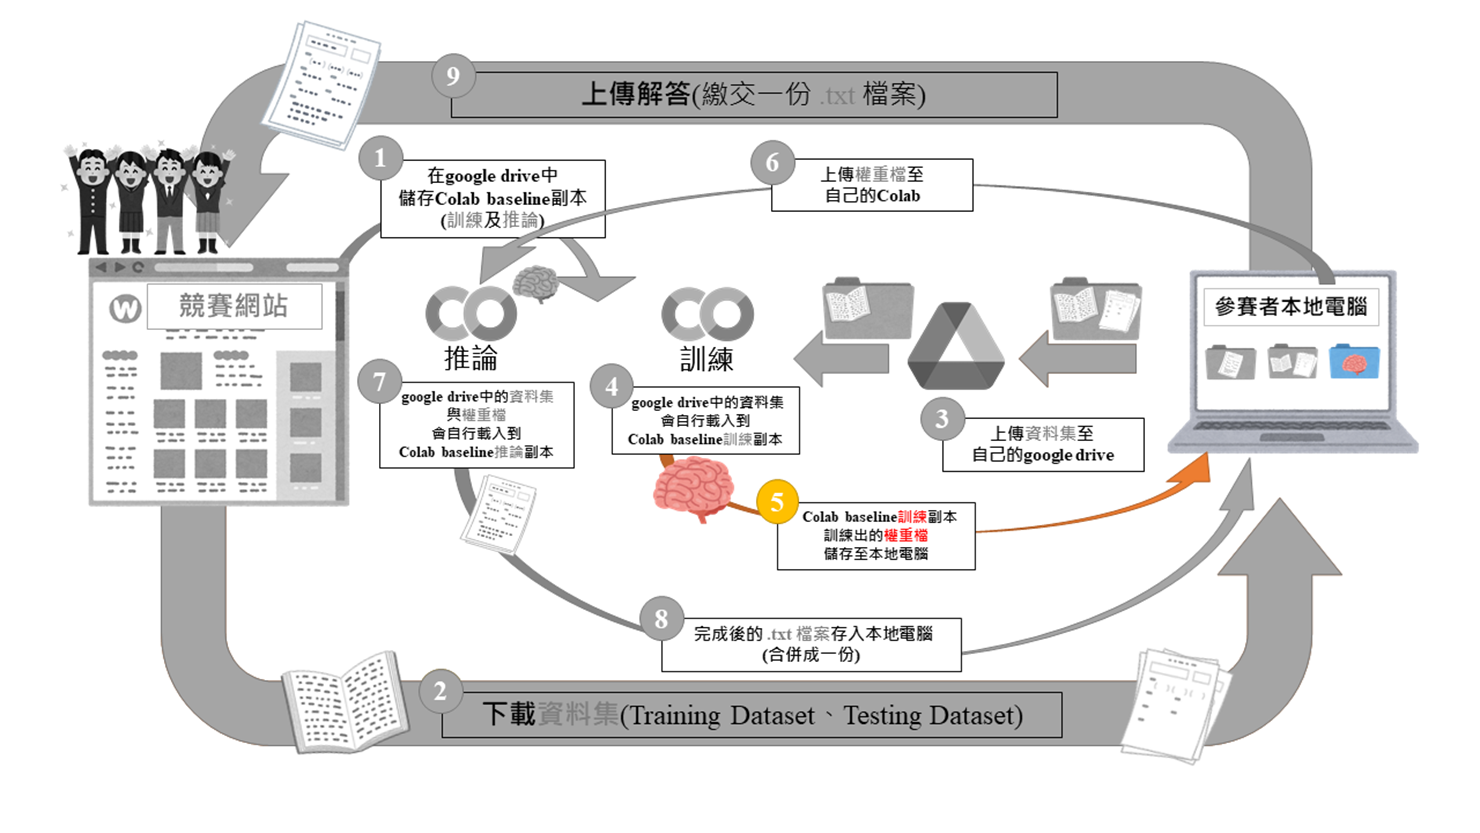

確認下方進度條消失才有下載成功 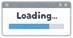

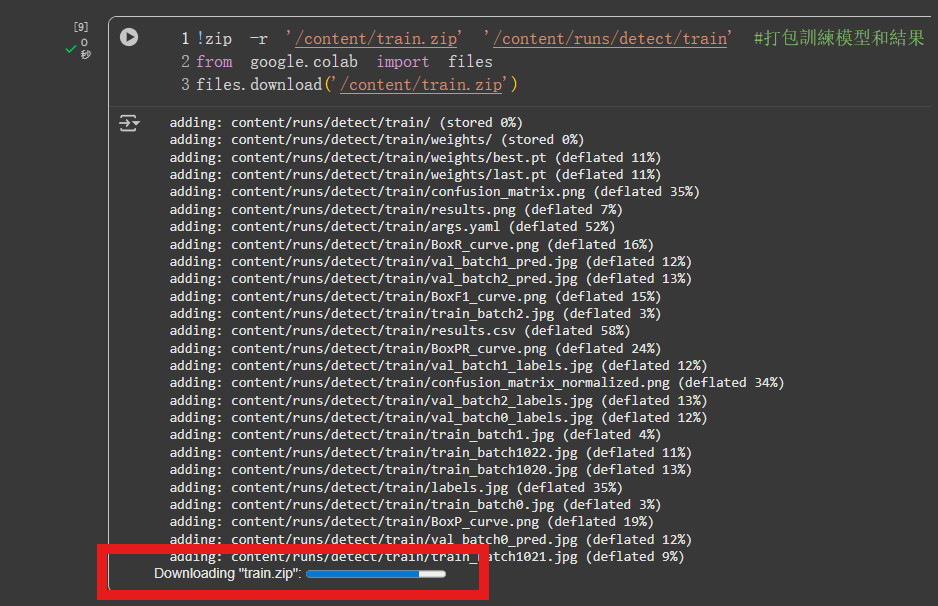

In [ ]:
!zip -r '/content/train.zip' '/content/runs/detect/train' #打包訓練模型和結果
from google.colab import files
files.download('/content/train.zip')

  adding: content/runs/detect/train/ (stored 0%)
  adding: content/runs/detect/train/labels.jpg (deflated 35%)
  adding: content/runs/detect/train/BoxF1_curve.png (deflated 16%)
  adding: content/runs/detect/train/val_batch1_labels.jpg (deflated 14%)
  adding: content/runs/detect/train/val_batch0_pred.jpg (deflated 13%)
  adding: content/runs/detect/train/val_batch2_labels.jpg (deflated 14%)
  adding: content/runs/detect/train/train_batch1.jpg (deflated 5%)
  adding: content/runs/detect/train/BoxR_curve.png (deflated 15%)
  adding: content/runs/detect/train/train_batch12421.jpg (deflated 9%)
  adding: content/runs/detect/train/train_batch12422.jpg (deflated 9%)
  adding: content/runs/detect/train/train_batch12420.jpg (deflated 11%)
  adding: content/runs/detect/train/train_batch2.jpg (deflated 3%)
  adding: content/runs/detect/train/val_batch0_labels.jpg (deflated 13%)
  adding: content/runs/detect/train/confusion_matrix.png (deflated 34%)
  adding: content/runs/detect/train/results.cs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

也可以右鍵直接下載best.pt和last.pt image.png

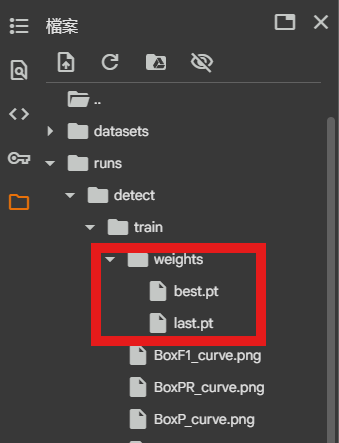

In [ ]:
!pip install -q gdown

# 用檔案 ID 下載
!gdown --id 1CJvQoYdNw4MfhX2CXuK_gv0Ar6iPc2s9 -O testing_image.zip

# 驗證 ZIP 是否正常
import zipfile
print("ZIP 檔是否有效：", zipfile.is_zipfile('testing_image.zip'))


/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1CJvQoYdNw4MfhX2CXuK_gv0Ar6iPc2s9
From (redirected): https://drive.google.com/uc?id=1CJvQoYdNw4MfhX2CXuK_gv0Ar6iPc2s9&confirm=t&uuid=00a935d3-e950-472b-8868-a48069c53144
To: /content/testing_image.zip
100% 1.83G/1.83G [00:29<00:00, 61.3MB/s]
ZIP 檔是否有效： True


In [ ]:
import os, shutil
os.makedirs("./datasets/test/tmp", exist_ok=True)
shutil.unpack_archive(r"testing_image.zip", "./datasets/test/tmp")

In [ ]:
import os
import shutil

base_root = "/content/datasets/test/tmp"
dst_root1 = "/content/datasets/test/images1"
dst_root2 = "/content/datasets/test/images2"

os.makedirs(dst_root1, exist_ok=True)
os.makedirs(dst_root2, exist_ok=True)

# 自動找到第一個「直屬子資料夾含 patient*」的目錄
patient_root = base_root
for dirpath, dirnames, _ in os.walk(base_root):
    if any(d.lower().startswith("patient") for d in dirnames):
        patient_root = dirpath
        break

# 收集所有圖片路徑（只看直屬的 patient 資料夾）
all_files = []
for patient_folder in os.listdir(patient_root):
    patient_path = os.path.join(patient_root, patient_folder)
    if os.path.isdir(patient_path) and patient_folder.lower().startswith("patient"):
        for fname in os.listdir(patient_path):
            if fname.lower().endswith(".png"):
                all_files.append(os.path.join(patient_path, fname))

# 按名稱排序並對半移動
all_files.sort()
half = len(all_files) // 2

for f in all_files[:half]:
    shutil.move(f, os.path.join(dst_root1, os.path.basename(f)))

for f in all_files[half:]:
    shutil.move(f, os.path.join(dst_root2, os.path.basename(f)))

print(f"來源根目錄：{patient_root}")
print(f"完成移動！總共 {len(all_files)} 張，前半 {half} 張到 images1，後半 {len(all_files)-half} 張到 images2")

來源根目錄：/content/datasets/test/tmp/testing_image
完成移動！總共 16620 張，前半 8310 張到 images1，後半 8310 張到 images2


In [ ]:
print('測試集圖片數量 : ',len(os.listdir(r"./datasets/test/images1")))

測試集圖片數量 :  8310


In [ ]:
print('測試集圖片數量 : ',len(os.listdir(r"./datasets/test/images2")))

測試集圖片數量 :  8310


In [ ]:
from ultralytics import YOLO

model = YOLO(r'runs/detect/train/weights/best.pt')
results = model.predict(source="./datasets/test/images1/",
              save=True,
              imgsz=640,
              device=0
              )

串流輸出內容已截斷至最後 5000 行。
image 3313/8310 /content/datasets/test/images1/patient0060_0359.png: 640x640 (no detections), 24.8ms
image 3314/8310 /content/datasets/test/images1/patient0060_0360.png: 640x640 (no detections), 18.1ms
image 3315/8310 /content/datasets/test/images1/patient0060_0361.png: 640x640 (no detections), 19.2ms
image 3316/8310 /content/datasets/test/images1/patient0060_0362.png: 640x640 (no detections), 18.9ms
image 3317/8310 /content/datasets/test/images1/patient0060_0363.png: 640x640 (no detections), 24.4ms
image 3318/8310 /content/datasets/test/images1/patient0060_0364.png: 640x640 (no detections), 20.3ms
image 3319/8310 /content/datasets/test/images1/patient0060_0365.png: 640x640 (no detections), 19.8ms
image 3320/8310 /content/datasets/test/images1/patient0060_0366.png: 640x640 (no detections), 17.5ms
image 3321/8310 /content/datasets/test/images1/patient0060_0367.png: 640x640 (no detections), 18.1ms
image 3322/8310 /content/datasets/test/images1/patient0060_0368.png: 6

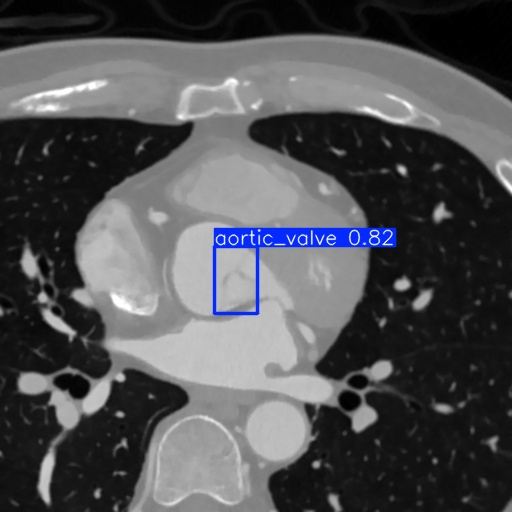

In [ ]:
from IPython.display import Image

Image(filename='/content/runs/detect/predict/patient0051_0260.jpg', height=600)

In [ ]:
print(len(results))

8310


In [ ]:
print('預測類別 : ',results[260].boxes.cls[0].item())
print('預測信心分數 : ',results[260].boxes.conf[0].item())
print('預測框座標 : ',results[260].boxes.xyxy[0].tolist())

預測類別 :  0.0
預測信心分數 :  0.8227903842926025
預測框座標 :  [214.9869842529297, 246.0662078857422, 259.92254638671875, 312.49609375]


In [ ]:
!mkdir ./predict_txt/
output_file = open('./predict_txt/images1.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框  if box_num > 0
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()

In [ ]:
import torch ,gc

# 刪除大型變數
del boxes,all_files,results
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO

model = YOLO('runs/detect/train/weights/best.pt')
results = model.predict(source="./datasets/test/images2/",
              save=True,
              imgsz=640,
              device=0
              )

串流輸出內容已截斷至最後 5000 行。
image 3313/8310 /content/datasets/test/images2/patient0086_0051.png: 640x640 (no detections), 15.1ms
image 3314/8310 /content/datasets/test/images2/patient0086_0052.png: 640x640 (no detections), 15.8ms
image 3315/8310 /content/datasets/test/images2/patient0086_0053.png: 640x640 (no detections), 14.7ms
image 3316/8310 /content/datasets/test/images2/patient0086_0054.png: 640x640 (no detections), 13.8ms
image 3317/8310 /content/datasets/test/images2/patient0086_0055.png: 640x640 (no detections), 14.2ms
image 3318/8310 /content/datasets/test/images2/patient0086_0056.png: 640x640 (no detections), 13.3ms
image 3319/8310 /content/datasets/test/images2/patient0086_0057.png: 640x640 (no detections), 14.0ms
image 3320/8310 /content/datasets/test/images2/patient0086_0058.png: 640x640 (no detections), 15.6ms
image 3321/8310 /content/datasets/test/images2/patient0086_0059.png: 640x640 (no detections), 14.0ms
image 3322/8310 /content/datasets/test/images2/patient0086_0060.png: 6

In [ ]:
output_file = open('./predict_txt/images2.txt', 'w')
for i in range(len(results)):
    # 取得圖片檔名（不含副檔名）
    filename = results[i].path.split('/')[-1].split('.png')[0]

    # 取得預測框數量
    boxes = results[i].boxes
    box_num = len(boxes.cls.tolist())

    # 如果有預測框
    if box_num > 0:
        for j in range(box_num):
            # 提取資訊
            label = int(boxes.cls[j].item())  # 類別
            conf = boxes.conf[j].item()       # 信心度
            x1, y1, x2, y2 = boxes.xyxy[j].tolist()  # 邊界框座標

            # 建立一行資料
            line = f"{filename} {label} {conf:.4f} {int(x1)} {int(y1)} {int(x2)} {int(y2)}\n"
            output_file.write(line)

# 關閉輸出檔案
output_file.close()

In [ ]:
file1 = "./predict_txt/images1.txt"
file2 = "./predict_txt/images2.txt"
output = "./predict_txt/merged.txt"

with open(output, "w", encoding="utf-8") as fout:
    for f in [file1, file2]:
        if os.path.exists(f):
            with open(f, "r", encoding="utf-8") as fin:
                fout.writelines(fin.readlines())

print(f"合併完成 -> {output}")

合併完成 -> ./predict_txt/merged.txt


In [ ]:
from google.colab import files
files.download('/content/predict_txt/merged.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>